In [1]:
import tensorflow as tf
import numpy as np                                
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import h5py
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
tf.random.set_seed(42)

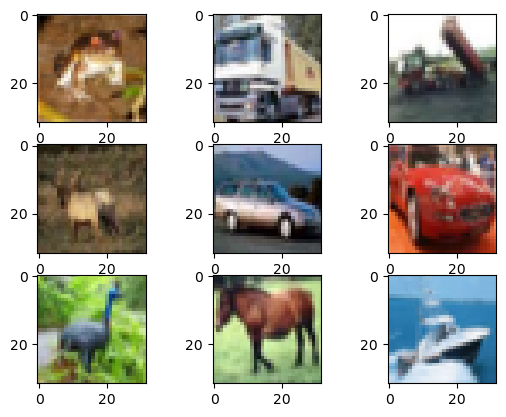

In [3]:
#load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_rows, img_cols , channels= 32,32,3
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
plt.show()

In [4]:
# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.3
    )
datagen.fit(x_train)

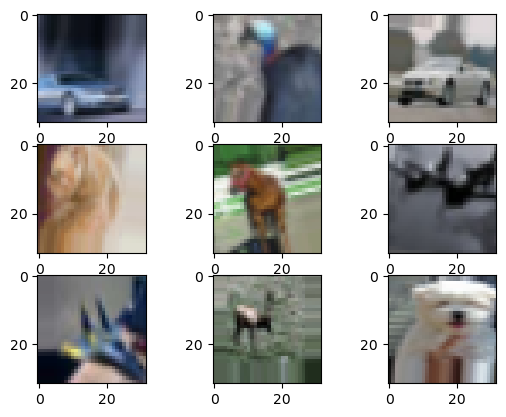

In [5]:
# see example augmentation images
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

In [6]:
#reshape into images
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [7]:
#convert integers to float; normalise and center the mean
x_train=x_train.astype("float32")  
x_test=x_test.astype("float32")
mean=np.mean(x_train)
std=np.std(x_train)
x_test=(x_test-mean)/std
x_train=(x_train-mean)/std

In [8]:
# labels
num_classes=10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [9]:
# build again, same model as model1

#reg=l2(1e-4)   # L2 or "ridge" regularisation
reg=None
reg2=None
num_filters=32
ac='relu'
adm=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt=adm
drop_dense=0.5
drop_conv=0

model = Sequential(name='cifar10')

model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, input_shape=(img_rows, img_cols, channels), padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filters, (3, 3), activation=ac,kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
model.add(Dropout(drop_conv))

model.add(Conv2D(2*num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(2*num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
model.add(Dropout(drop_conv))

model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
model.add(Dropout(drop_conv))

model.add(Flatten())
model.add(Dense(2048, activation=ac, kernel_regularizer=reg2, name='hidden_1'))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(2048, activation=ac, kernel_regularizer=reg2, name='hidden_2'))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(1024, activation=ac, kernel_regularizer=reg2, name='hidden_4'))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(512, activation=ac, kernel_regularizer=reg2, name='hidden_5'))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(num_classes, activation='softmax', name='output'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)

In [10]:
model.summary()

Model: "cifar10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1849

In [11]:
checkpoint = ModelCheckpoint("cifar10_best_result1.h5", save_best_only=True)

In [12]:
# train with image augmentation
history=model.fit(datagen.flow(x_train, y_train, batch_size=256),
                    steps_per_epoch = len(x_train) / 256, epochs=200, 
                  validation_data=(x_test, y_test), callbacks=[checkpoint])

Epoch 1/200
196/195 [==============================] - 23s 120ms/step - loss: 2.1129 - accuracy: 0.3169 - val_loss: 3.1237 - val_accuracy: 0.1542
Epoch 2/200
196/195 [==============================] - 24s 121ms/step - loss: 1.5136 - accuracy: 0.4620 - val_loss: 1.3443 - val_accuracy: 0.5185
Epoch 3/200
196/195 [==============================] - 24s 123ms/step - loss: 1.3021 - accuracy: 0.5374 - val_loss: 1.0991 - val_accuracy: 0.6168
Epoch 4/200
196/195 [==============================] - 22s 114ms/step - loss: 1.1508 - accuracy: 0.5943 - val_loss: 0.9681 - val_accuracy: 0.6630
Epoch 5/200
196/195 [==============================] - 22s 114ms/step - loss: 1.0427 - accuracy: 0.6330 - val_loss: 0.9156 - val_accuracy: 0.6877
Epoch 6/200
196/195 [==============================] - 23s 116ms/step - loss: 0.9620 - accuracy: 0.6632 - val_loss: 0.9951 - val_accuracy: 0.6726
Epoch 7/200
196/195 [==============================] - 22s 114ms/step - loss: 0.8944 - accuracy: 0.6877 - val_loss: 0.9773 -

Epoch 57/200
196/195 [==============================] - 26s 130ms/step - loss: 0.3218 - accuracy: 0.8894 - val_loss: 0.4278 - val_accuracy: 0.8672
Epoch 58/200
196/195 [==============================] - 24s 121ms/step - loss: 0.3196 - accuracy: 0.8904 - val_loss: 0.3570 - val_accuracy: 0.8853
Epoch 59/200
196/195 [==============================] - 27s 140ms/step - loss: 0.3103 - accuracy: 0.8928 - val_loss: 0.3461 - val_accuracy: 0.8898
Epoch 60/200
196/195 [==============================] - 24s 124ms/step - loss: 0.3141 - accuracy: 0.8911 - val_loss: 0.3392 - val_accuracy: 0.8899
Epoch 61/200
196/195 [==============================] - 24s 122ms/step - loss: 0.3103 - accuracy: 0.8924 - val_loss: 0.3768 - val_accuracy: 0.8790
Epoch 62/200
196/195 [==============================] - 25s 129ms/step - loss: 0.3067 - accuracy: 0.8963 - val_loss: 0.3754 - val_accuracy: 0.8786
Epoch 63/200
196/195 [==============================] - 23s 117ms/step - loss: 0.3019 - accuracy: 0.8975 - val_loss: 0

196/195 [==============================] - 22s 113ms/step - loss: 0.1671 - accuracy: 0.9417 - val_loss: 0.3751 - val_accuracy: 0.8938
Epoch 168/200
196/195 [==============================] - 22s 113ms/step - loss: 0.1699 - accuracy: 0.9409 - val_loss: 0.3336 - val_accuracy: 0.9040
Epoch 169/200
196/195 [==============================] - 22s 114ms/step - loss: 0.1634 - accuracy: 0.9441 - val_loss: 0.3056 - val_accuracy: 0.9127
Epoch 170/200
196/195 [==============================] - 22s 113ms/step - loss: 0.1657 - accuracy: 0.9427 - val_loss: 0.3484 - val_accuracy: 0.9025
Epoch 171/200
196/195 [==============================] - 22s 112ms/step - loss: 0.1654 - accuracy: 0.9424 - val_loss: 0.3114 - val_accuracy: 0.9095
Epoch 172/200
196/195 [==============================] - 22s 114ms/step - loss: 0.1644 - accuracy: 0.9433 - val_loss: 0.3319 - val_accuracy: 0.9028
Epoch 173/200
196/195 [==============================] - 22s 112ms/step - loss: 0.1605 - accuracy: 0.9445 - val_loss: 0.3431 -

In [13]:
# plotting helper function
def plothist(hist):
    plt.rcParams["figure.figsize"] = (16, 8)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()
    plt.show()

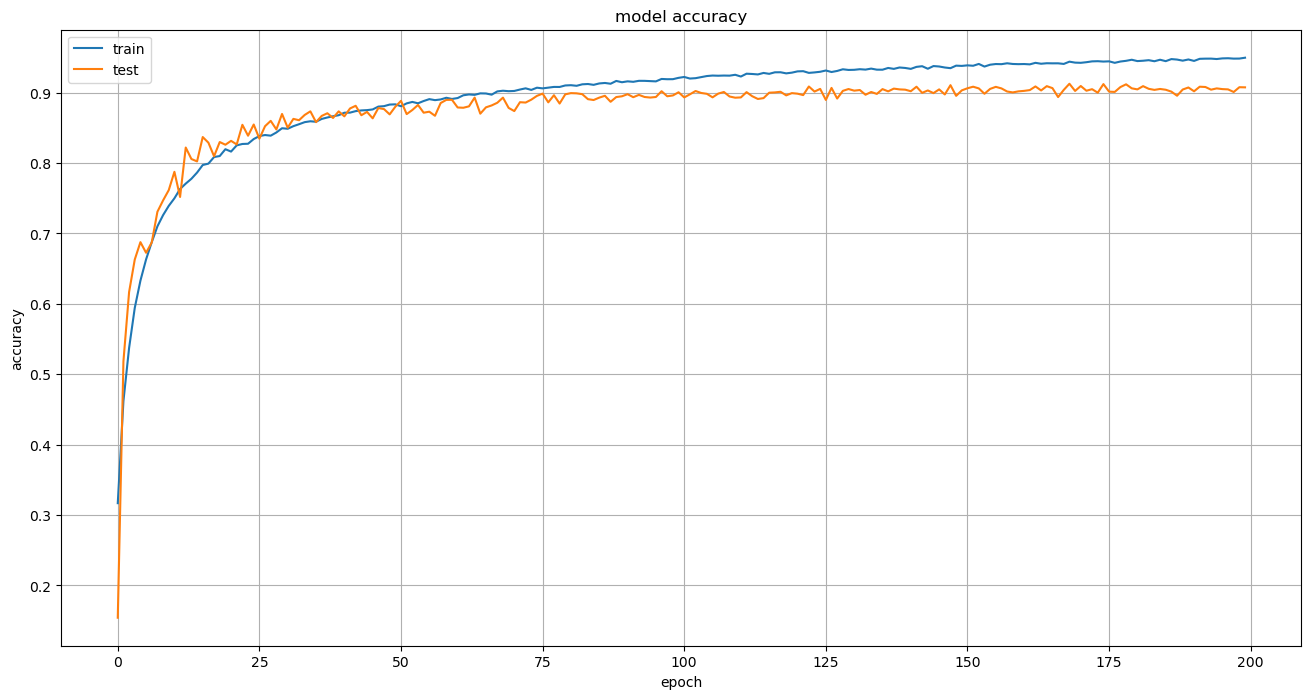

In [14]:
plothist(history)

In [15]:
model_test_acc=model.evaluate(x_test,y_test, batch_size=128)
model_test_acc

79/79 [==============================] - 1s 9ms/step - loss: 0.3187 - accuracy: 0.9076


[0.31870338320732117, 0.9075999855995178]

In [16]:
model_train_acc=model.evaluate(x_train,y_train, batch_size=128)
model_train_acc

391/391 [==============================] - 4s 10ms/step - loss: 0.0354 - accuracy: 0.9890


[0.03540723770856857, 0.9890400171279907]

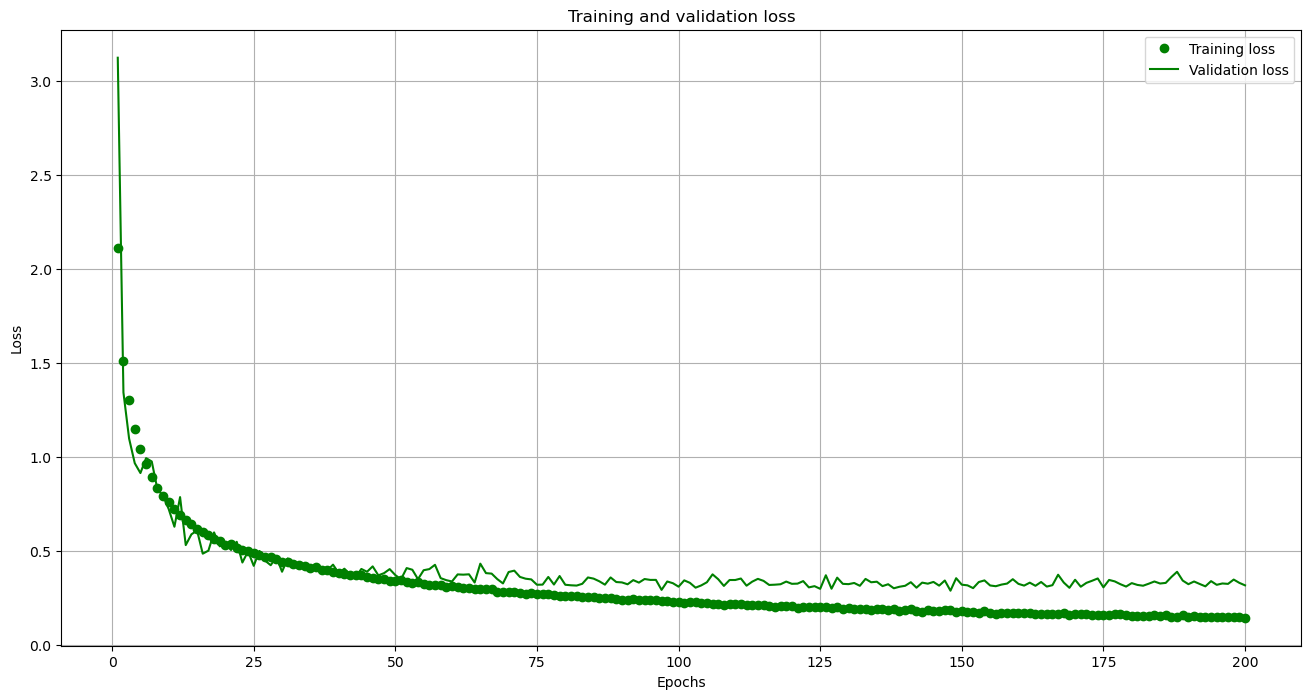

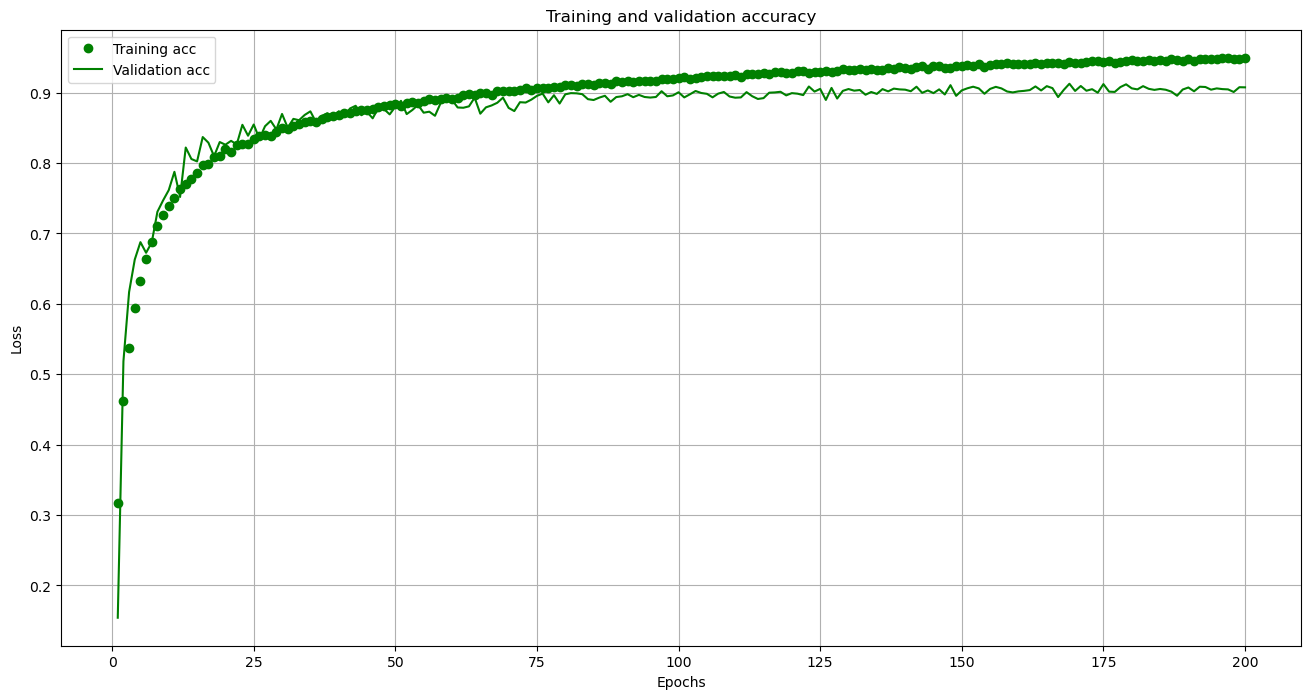

In [17]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.rcParams["figure.figsize"] = (16, 8)
plt.plot(epochs, loss_values, 'go', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.plot(epochs, history_dict['accuracy'], 'go', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [18]:
model.save("cifar10_best1.h5")

In [19]:
model.save("cifar10_best1.hdf5")

In [20]:
model.save_weights("cifar10_best1.h5")